# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat
from scipy.sparse import bsr_matrix

from geo_annulus import *
#from multipatch_block_handler import *
from plots import *
from ass_nonlin_el import *
from solver import *
from line_search import *


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
 no MKL


In [2]:
p = 3 #3  # spline degree 
x_el= 40
y_el= 8
#n_el = (y_el, x_el)#number of elements in y/x direction
n_el = (x_el, y_el) #  isotropic material
# displacement space: degree p,   continuity p-1
multi= p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
#m_u = tuple(kv.numdofs for kv in kvs_u)

In [3]:
r_in = 3.7
r_out = 4.5

#r_in = 0.0031 ##m
#r_out = 0.004 #m
geos = geo_annulus(r_in, r_out)

In [4]:
patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True)

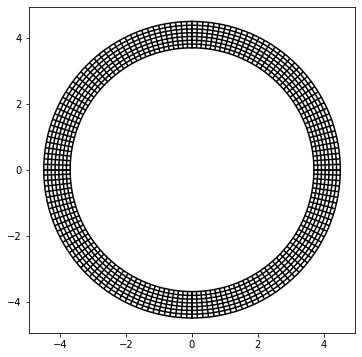

In [5]:

fig, ax = plt.subplots(figsize=(8,6))
for g in geos:
    vis.plot_geo(g, gridx=np.linspace(0, 1, x_el), gridy=np.linspace(0, 1, y_el))
ax.axis('scaled');

#scale_factor = 1000

#xmin, xmax = plt.xlim()
#ymin, ymax = plt.ylim()
#plt.xlim(xmin * scale_factor, xmax * scale_factor)
#plt.ylim(ymin * scale_factor, ymax * scale_factor)

In [6]:
## set blocks for x and y component

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )


In [7]:
# source term f 
def f(x, y): return (0.0, 0.0)

#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
def gN(x, y): 
    return (x/r_in*l_val, y/r_in*l_val)  #inner  pressure, normalized vector

# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)


# Robin BC
def g_robin(x, y): 
    return ( 1-(x/r_out+ y/r_out)**2) # scalar value
    

In [8]:

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero ) 
])


In [9]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [10]:
#incremental loading
maxload = 1.5e-3 #2e-3
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [11]:
# function is zero!!
#robin_data = [(1, 'right', g_zero, 1)] # instead of Dirichlet-bdc, outer bd fixed


In [19]:
alpha =1e-2# 1.5e3# 1e0 # 1e4 max penalization!
robin_data = [(1, 'right', g_robin, alpha)] # instead of Dirichlet-bdc, outer bd fixed

#robin_data = [(1, 'right', g_zero, 1)] # instead of Dirichlet-bdc, outer bd fixed

In [20]:
# assemble Robin-matrix
AR = ass_Robin(MP_block, robin_data)

In [21]:
def J(u):
    return ass_energy(u, MP_block, kvs_j, neu_data, robin_data)


def grad_J(u):
    return -ass_rhs_RN(u, MP_block, neu_data, AR)

# TODO: It is inefficient to:
#           (i)   compute A if only grad_J is used,
#           (ii)  compute A and/or b repeatedly for the same u,
#           (iii) recompute the vector from the Neumann conditions for rhs (term needs re-scaling for changes of scaling),
#           (iv)  recompute the Robin matrix.
# Further impovement possible by using "updatable" field as in the solve-navier-stokes example.

use SuperLU
Residual0 = 0.007215803116717233
Energy0   = 0.0
use SuperLU
Residual  = 0.015288057253221049
Energy    = -0.014519398611054519


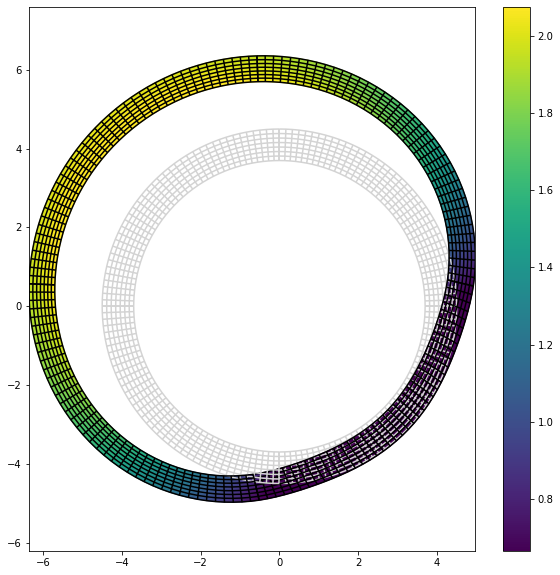

In [22]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

### first iteration ###
A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR) # with Robin-matrix

M = ass_mass(MP_block)
Minv = make_solver(M)

r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(A).dot(b) 
u += u_d

#A, b = ass_nonlinsystem(u, MP_block, neu_data, AR) 
#print('rhs:', b)
b= ass_rhs_RN( u, MP_block, neu_data, AR)
#print('rhs:', b)

r = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual  =', r)
print('Energy    =', J(u))

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [23]:
#get_defplotPP(u, patches_u, kvs_u, MP_u, n_el, r_in, r_out)

Norm of rhs for max loading: 0.007215803116717233
Tolerance:                   7.215803116717233e-07
 
 
 1. loading: 0.0005 

Residual = 0.0008017559018574702
Energy   = 0.0
1
use SuperLU
residual = 0.0002286915932329289
energy   = -0.002242404144558647
2
use SuperLU
residual = 2.1304918904913666e-05
energy   = -0.002305577259261554
3
use SuperLU
residual = 9.304406438522672e-08
energy   = -0.0023086120840497774
u=  [0.1491603  0.14669519 0.14431549 ... 0.2182102  0.21806163 0.21791279]
 
 
 2. loading: 0.001 

Residual = 0.0008060147554299433
Energy   = -0.006761861107730189
1
use SuperLU
residual = 0.0001182031301069277
energy   = -0.008650362587736667
2
use SuperLU
residual = 2.2625240130281627e-06
energy   = -0.00867342411572908
3
use SuperLU
residual = 1.304965024224216e-07
energy   = -0.008673846242811667
u=  [0.27181238 0.26662134 0.26166323 ... 0.40885093 0.40859203 0.40833246]
 
 
 3. loading: 0.0015 

Residual = 0.000803136639442309
Energy   = -0.01686064959976826
1
use Supe

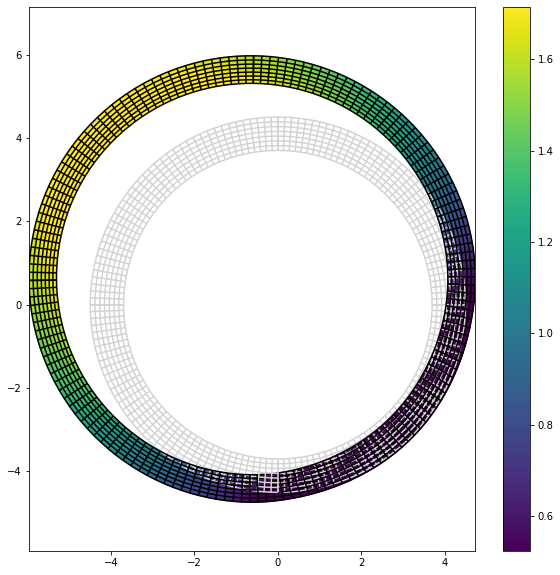

In [24]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
#M = ass_mass(MP_block)
#Minv = make_solver(M)
r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
#r0 = np.linalg.norm(b)


print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    count = 0
    while True:
        count+=1

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
            r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
            #r = np.linalg.norm(b)
            print('Residual =',r)
            print('Energy   =',J(u))
        #else: # Use from last iteration; see below (*)
        #    A, b = ass_nonlinsystem_RN(u)
            
        print(count)

        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(A).dot(b)
        u += u_d            

        # Compute new non-linear residual, already to be used for next iteration (*)
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm 
        #r= np.linalg.norm(b)
        print('residual =', r)
        print('energy   =', J(u))
        
        #w1 = np.linalg.inv(A.todense()).dot(b)-u  #TODO: Use solver instead of inverse !!! 
        #w1 = make_solver_orig(A).dot(b)-u         #TODO: We do not want to solve that often!!
        #w2 = b - A.dot(u)
        #err= np.sqrt(np.abs(np.inner(w1,w2)))
        #print('Error=', err)

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [25]:
#(last) energy ngsolve: -13.463597628336885
#-13.463608858454057


 patch: 0
inner radius_0= 4.107772777967368
outer radius_0= 4.75850432032018
displacement_inner= [0.37746243 0.49809367]
displacement_outer= [0.23547424 0.46759718]
dis_inner_x/dis_outer_x:  1.6029882440382692
dis_inner_y/dis_outer_y:  1.0652195794365518
 ratio_inner: 1.1102088589100993
 ratio_outer: 1.0574454045155954

 patch: 1
inner radius_0= 4.1077727779673605
outer radius_0= 4.7585043203201725
displacement_inner= [-0.49809367 -0.37746243]
displacement_outer= [-0.46759718 -0.23547424]
dis_inner_x/dis_outer_x:  1.0652195794365502
dis_inner_y/dis_outer_y:  1.6029882440382948
 ratio_inner: 1.1102088589100974
 ratio_outer: 1.0574454045155939

 patch: 2
inner radius_0= 5.3418545087210525
outer radius_0= 5.998212910990596
displacement_inner= [-1.60921958  0.58957361]
displacement_outer= [-1.46992092  0.58189545]
dis_inner_x/dis_outer_x:  1.0947660897841895
dis_inner_y/dis_outer_y:  1.0131950932380756
 ratio_inner: 1.4437444618165005
 ratio_outer: 1.3329362024423548

 patch: 3
inner radi

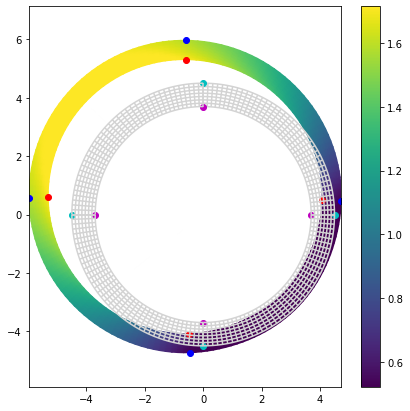

In [26]:
get_defplotPP(u, patches_u, kvs_u, MP_u, n_el, r_in, r_out)

In [ ]:
iter_counts

In [ ]:
# ngsolve for maxload = 9e-2 and 3 steps#, (4,4,3) Newton iterations
# 2e-1: (4,4,3) (zero based)
# 4e-1: (5,4,4) #iga(2, 4, 3), [2, 3, 5, 3, 2]
# 5e-1: (5,4,4)
# 6e-1: (5,4,4) 8e-1
# 1e0: (5,4,5)

In [ ]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [ ]:
s_sol= shape(solutions)[0]

In [ ]:
s_sol


In [ ]:
from IPython.display import HTML

figsize(14, 4)
s_sol= shape(solutions)[0]
fields = [solutions[tt] for tt in range(s_sol)]
HTML(animate_field(fields, patches_u, kvs_u, MP_u, res=(50,70), interval=335, progress=True).to_html5_video())

In [ ]:
plt.clf()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
res=(50,70)
#vrange=(0.0, 1.5e-3)

s_sol= shape(solutions)[0]
ims = []
ar= np.linspace(1,2, s_sol)
factor = 1


#fields = list(ud_array)
fields = list(solutions)

for tt in range(s_sol):
    #u = LS.complete(fields[tt])
    u = fields[tt]
    factor = ar[tt] # choose factor for deformation plot
    vrange = None
    ims_q = []
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:]

    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
            for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
            for p in range(len(patches_u))]
    plt.ioff()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        im_q=[]
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            #vrange = (0.0, 1.5e-3)
            vrange = (C.min(), C.max())
        im_q = plt.pcolormesh(XY[..., 0] + factor*dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1], axes=ax) # shading for smoothing
        
        im_q.set_array(C.ravel()) 
        ims_q.append(im_q) 
    
    ims.append(ims_q)
    #print(shape(ims))
#print(ims[0])
    
#fig.colorbar(im_q, ax=ax);
colorbar();
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat= False) # repeat_delay=2000



#ani.to_html5_video()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'))
#ani.save("rtest.mp4", writer=writer )
vid = ani.to_html5_video()

plt.close()



In [ ]:
ani

In [ ]:
# last energy inb ngsolve: 
#Energy:  -13.463604635795463

In [ ]:
# Line search based on energy
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann data


A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
r0= np.transpose(b).dot(Minv.dot(b)) #Dual of L2-norm

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###



J0 = 0

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)]
    
    # first residuum
    A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
    r = np.transpose(b).dot(Minv.dot(b)) #Dual of L2-norm
    print('Residual=', r)

    count= 0
    rejected = False
    
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        u_d = make_solver(A).dot(b) 
        
        alpha = 1.
        J1 = J(u+alpha*u_d)
        print("alpha = {} gives energy {}".format(alpha, J1))
        downfactor = .7
        upfactor   = 1.3
        
        while J1>J0:
            alpha *= downfactor
            J1 = J(u+alpha*u_d)
            print("alpha = {} gives energy {}".format(alpha, J1))
        if alpha == 1.:
            J2 = J(u+upfactor*alpha*u_d)
            print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
            while J2<J1:
                alpha *= upfactor
                J1 = J2
                J2 = J(u+upfactor*alpha*u_d)
                print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
        print("alpha = {}".format(alpha))
        u += alpha * u_d       
            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #Dual of L2-norm
        print('residual = {}'.format(r))
        J0 = J(u)
        print('energy   = {}'.format(J0))


        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(np.array(u))
    iter_counts.append(count)
        

print("done")

In [ ]:
        
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [ ]:
# energy ngsolve: -13.463608858454057 (old val )
#  -14076.201755344253

In [ ]:
get_defplot(u, patches_u, kvs_u, MP_u, n_el)

In [ ]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [ ]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [ ]:
get_defplotPP(u, patches_u, kvs_u, MP_u, n_el, r_in, r_out)

In [ ]:
# Line search based on energy (line search)
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

# residuum for max. loadig
b = ass_rhs_RN(u, MP_block, neu_data, AR)
r0= np.transpose(b).dot(Minv.dot(b)) #Dual of L2-norm

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

J0 = 0

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann
    
    count= 0
    rejected = False
    
    while True:
        count+=1
        if count == 1:
            # first residuum for incremental loading
            A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
            r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
            #r = np.linalg.norm(b)
            print('Residual =',r)
            print('Energy   =',J(u))
        print(count)


        # Assemble matrices and rhs in every iteration step
        #A, b = ass_nonlinsystem(u, MP_block, neu_data, AR)
        u_d = make_solver(A).dot(b) 
        
        # check if matrix is positive definite in a particular direction u_d
        sp = b.dot(A @ u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))

       ## # # do Wolfe-Powell line search # # ###
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        print('alpha=', alpha)
        
        if alpha == None:           
            print('Use line search based on energy:')
            alpha = 1.
            J1 = J(u+alpha*u_d)
            print("alpha = {} gives energy {}".format(alpha, J1))
            downfactor = .7
            upfactor   = 1.3

            while J1>J0:
                alpha *= downfactor
                J1 = J(u+alpha*u_d)
                print("alpha = {} gives energy {}".format(alpha, J1))
            if alpha == 1.:
                J2 = J(u+upfactor*alpha*u_d)
                print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
                while J2<J1:
                    alpha *= upfactor
                    J1 = J2
                    J2 = J(u+upfactor*alpha*u_d)
                    print("alpha = {} gives energy {}".format(upfactor*alpha, J2))
            print("alpha = {}".format(alpha))
            
        u += alpha * u_d       
            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #Dual of L2-norm
        print('residual = {}'.format(r))
        J0 = J(u)
        print('energy   = {}'.format(J0))
        
        w1 = np.abs(make_solver(A).dot(b)-u)        #TODO: We do not want to solve that often!!
        w2 = np.abs(b - A.dot(u))
        err= np.sqrt(np.inner(w1,w2))
        print('Error=', err)


        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u, MP_u, n_el)
print("done")

In [ ]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

In [ ]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [ ]:
u

In [ ]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

    dis = get_components(X.T @ u, kvs_ux)
    detF= sum(assemble.assemble( '(grad(dis)[0,0]+grad(dis)[1,1]+2)  * aux * dx',kvs_ux, bfuns=[('aux',1)], geo=geo_ux, dis=dis).ravel())
    print(detF)

In [ ]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

    dis = get_components(X.T @ u, kvs_ux)
    detF= sum(assemble.assemble( '(tr(grad(dis))+2)  * aux * dx',kvs_ux, bfuns=[('aux',1)], geo=geo_ux, dis=dis).ravel())
    print(detF)

In [ ]:
# 1st loading
#residual = 7.354603676319553
#energy   = -1872.2771537448261
#Error= 435.8757417364093

# Energy (last): #  -14076.201755344253

In [ ]:
def func_sol(MP_block, AR):
    # solve linearized variational problem - iterative, without line-search
    X= MP_block.patch_to_global(2)# patch 2
    dd = shape(X)[0]
    #initial value
    u= np.zeros(dd)

    epsilon= 1e-4# 1e-5

    solutions = []
    stepsizes = [] 
    ud_array = []
    iter_counts = []


    ### Linear elasticity for largest loading
    l_val = loading[-1] # take last loading value
    neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

    A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
    M = ass_mass(MP_block)
    Minv = make_solver(M)
    r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
    #r0 = np.linalg.norm(b)


    #print("Norm of rhs for max loading: {}".format(r0))
    #print("Tolerance:                   {}".format(r0*epsilon))
###

    # incremental loading # ----------------------------------
    for t in range(len(loading)): # time steps
        print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))

        # set Neumann data via incremental loading
        l_val = loading[t]
        neu_data = [(0,'left',gN, l_val), (1,'left',gN, l_val), (2,'left',gN, l_val), (3,'left',gN, l_val)] # set neumann

        count = 0
        while True:
            count+=1

            # Assemble matrices and rhs in every iteration step
            if count == 1:
                A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
                r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm

            print(count)

            # # solve system # #
            #u_d = make_solver(A).dot(b) 
            u_d = make_solver(A).dot(b)
            u += u_d            

            # Compute new non-linear residual, already to be used for next iteration (*)
            A, b = ass_nonlinsystem_RN(u, MP_block, neu_data, AR)
            r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm 


            if r < epsilon * r0: # break condition
                break
            elif count == 30:
                break
        # 
        print('u= ' , u)
        #solutions.append(np.array(u))
    return u

In [ ]:
func_sol(MP_block, AR)

In [ ]:
split_u(u, MP_u, kvs_u, patches_u)# patch3

In [ ]:
h_rate = 1


for k in range(1,5):
    h_rate*=2**(-k)
    print(h_rate)
    
    
#y_val=np.zeros(len(h_rate))
#x_val=np.zeros(len(h_rate))


In [ ]:
h_rate =1
h_i = h_rate


for k in range(1,5):
    h_rate*=2
    print(h_rate)
    h_i = np.append(h_i,h_rate)
    

In [ ]:
h_i

In [ ]:
r_val=np.zeros(len(h_i))

In [ ]:
def func_pp(pp, n_el, geos):
    
    multi= pp-1
    kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
    patches_u = [(kvs_u, g) for g in geos]

    # Here we auto-detect the interfaces between the patches.
    MP_u = assemble.Multipatch(patches_u, automatch=True)
    # Multipatch objects for all variables
    MP_block = multipatch_block_handler( [MP_u, MP_u] )
    # set up Dirichlet boundary conditions
    bc = MP_block.compute_dirichlet_bcs([
        (1, 'right', g_zero ) 
    ])
    
    # define constant spline functions for integration
    kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration
    # assemble Robin-matrix
    AR = ass_Robin(MP_block, robin_data)

    count=0

    x_el = n_el[0]
    y_el = n_el[1]
    xgrid=np.linspace(0, 1, x_el)
    ygrid=np.linspace(0, 1, y_el)
    xygrid = (xgrid, ygrid)

    u = func_sol(MP_block, AR)
    u1_funcs, u2_funcs = split_u(u, MP_u, kvs_u, patches_u)
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
            count+=1
            if count==2:
                print('\n patch:', count)
                #func_p(pp, geo, n_el, xygrid)
                G = geo.grid_eval(xygrid)

                dis1 = u1_func.grid_eval(xygrid) #x-value
                dis2 = u2_func.grid_eval(xygrid) #y-value
                return dis1, dis2, G
        

In [ ]:
# figure of maximum deflection at the end of the beam; evaluated at different polynomial degree's p

figsize(10,10)
ax = plt.figure().gca()
for pp in range(1,4):# degree p
    for i in range(0, len(h_i)):
        n_el = (5*h_i[i], h_i[i]) # 5:1 (e.g.: 40:8)
        dis1, dis2, G= func_pp(pp, n_el, geos) # p=2 or p=3 fix
        radius_inner = np.sqrt( (G[0,0, 0]+dis1[0, 0])**2 + (G[0,0, 1]+dis2[0,0])**2)
        r_val[i] = radius_inner
    plt.plot(r_val, label =pp)
    
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Refinement for different degrees p')
plt.xlabel('refinement steps')
plt.ylabel('inner radius')

plt.legend()
plt.show()